# LSTM

_https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/_

### Setup

In [65]:
# import pandas
import pandas as pd

# import matplotlib
%matplotlib inline
import matplotlib

plt = matplotlib.pyplot
matplotlib.rcParams['figure.figsize'] = [15, 8]

# preprocessing
from sklearn.preprocessing import MinMaxScaler

# models
import tensorflow as tf
print(tf.config.list_physical_devices())

# saving
import pickle

# misc
import numpy as np
from scipy.signal import savgol_filter


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load Observations

                           airtemp  cloudcover  precip  107337_00065  \
2008-01-01 06:15:00+00:00     -7.0         2.0     0.0          4.88   
2008-01-01 06:30:00+00:00     -7.5         3.0     0.0          4.88   
2008-01-01 06:45:00+00:00     -8.0         3.0     0.0          4.88   
2008-01-01 07:00:00+00:00     -7.5         1.9     0.0          4.88   
2008-01-01 07:15:00+00:00     -7.0         1.8     0.0          4.87   

                           107338_00010  
2008-01-01 06:15:00+00:00           1.9  
2008-01-01 06:30:00+00:00           1.9  
2008-01-01 06:45:00+00:00           1.9  
2008-01-01 07:00:00+00:00           1.9  
2008-01-01 07:15:00+00:00           1.9  


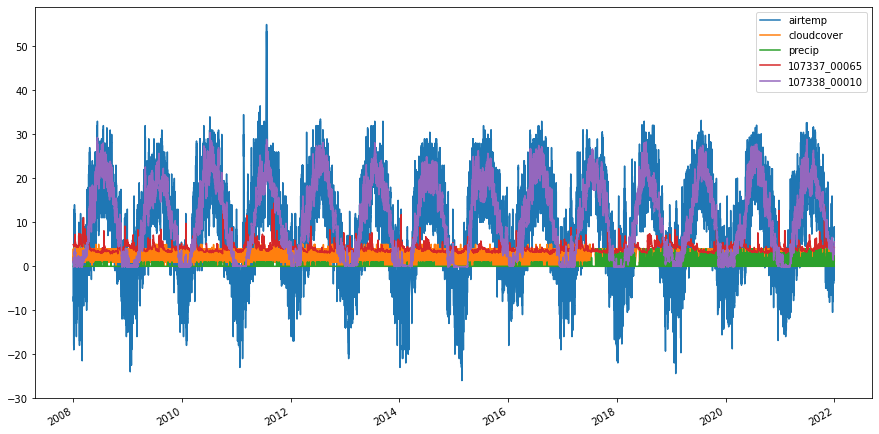

In [66]:
observations = pd.read_pickle('output/observations.pickle')

print(observations.head())
observations.plot()
plt.show()

### Prepare Dataframe for LSTM

In [67]:
values = observations.values

# ensure values are floats
values = values.astype('float')

# normalize features
in_values = values[:, 0:3]
out_values = values[:, 3:6]
in_scaler = MinMaxScaler(feature_range=(0, 1))
out_scaler = MinMaxScaler(feature_range=(0, 1))
in_scaled = in_scaler.fit_transform(in_values)
out_scaled = out_scaler.fit_transform(out_values)
scaled = pd.DataFrame(np.hstack((in_scaled, out_scaled)))

pickle.dump(in_scaler, open('output/in_scaler.pickle', 'wb'))
pickle.dump(out_scaler, open('output/out_scaler.pickle', 'wb'))

# ! revisit
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_in_vars=None, n_out=1, n_out_vars=None, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	if n_in_vars is None: n_in_vars = list(range(n_vars))
	if n_out_vars is None: n_out_vars = list(range(n_vars))
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df[n_in_vars].shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in n_in_vars]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df[n_out_vars].shift(-i))
		if i == 0:
			# cols.append(df.shift(-i))
			names += [('var%d(t)' % (j+1)) for j in n_out_vars]
		else:
			# cols.append(df[n_out_vars].shift(-i))
			names += [('var%d(t+%d)' % (j+1, i)) for j in n_out_vars]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# reframe data
# look back 2 days, forward 4
reframed = series_to_supervised(scaled, 4, None, 1, None)
print(reframed.head())

   var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var1(t-3)  \
4   0.234568       0.40        0.0   0.183074   0.071661   0.228395   
5   0.228395       0.60        0.0   0.183074   0.071661   0.222222   
6   0.222222       0.60        0.0   0.183074   0.071661   0.228395   
7   0.228395       0.38        0.0   0.183074   0.071661   0.234568   
8   0.234568       0.36        0.0   0.182211   0.071661   0.234568   

   var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  ...  var1(t-1)  var2(t-1)  \
4       0.60        0.0   0.183074   0.071661  ...   0.228395       0.38   
5       0.60        0.0   0.183074   0.071661  ...   0.234568       0.36   
6       0.38        0.0   0.183074   0.071661  ...   0.234568       0.34   
7       0.36        0.0   0.182211   0.071661  ...   0.240741       0.30   
8       0.34        0.0   0.182211   0.071661  ...   0.246914       0.26   

   var3(t-1)  var4(t-1)  var5(t-1)   var1(t)  var2(t)  var3(t)   var4(t)  \
4        0.0   0.183074   0.071661  0.23

### Split Train/Test

In [68]:
values = reframed.values
train_portion = 0.8 # 80%
divider = int(len(values) * train_portion)

train = values[:divider, :]
test = values[divider:, :]

train_X, train_y = train[:, :-2], train[:, -2:]
test_X, test_y = test[:, :-2], test[:, -2:]

# reshape
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(390220, 1, 23) (390220, 2) (97556, 1, 23) (97556, 2)


### Create Model

Epoch 1/100


2022-06-26 01:14:33.548445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-26 01:14:43.812312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 - 12s - loss: 0.1976 - val_loss: 0.1612 - 12s/epoch - 1s/step
Epoch 2/100
12/12 - 9s - loss: 0.1335 - val_loss: 0.0932 - 9s/epoch - 777ms/step
Epoch 3/100
12/12 - 9s - loss: 0.0753 - val_loss: 0.0496 - 9s/epoch - 786ms/step
Epoch 4/100
12/12 - 9s - loss: 0.0462 - val_loss: 0.0387 - 9s/epoch - 779ms/step
Epoch 5/100
12/12 - 9s - loss: 0.0363 - val_loss: 0.0343 - 9s/epoch - 781ms/step
Epoch 6/100
12/12 - 9s - loss: 0.0315 - val_loss: 0.0300 - 9s/epoch - 781ms/step
Epoch 7/100
12/12 - 9s - loss: 0.0278 - val_loss: 0.0281 - 9s/epoch - 784ms/step
Epoch 8/100
12/12 - 9s - loss: 0.0246 - val_loss: 0.0223 - 9s/epoch - 780ms/step
Epoch 9/100
12/12 - 9s - loss: 0.0189 - val_loss: 0.0193 - 9s/epoch - 789ms/step
Epoch 10/100
12/12 - 9s - loss: 0.0166 - val_loss: 0.0193 - 9s/epoch - 780ms/step
Epoch 11/100
12/12 - 9s - loss: 0.0142 - val_loss: 0.0119 - 9s/epoch - 774ms/step
Epoch 12/100
12/12 - 10s - loss: 0.0106 - val_loss: 0.0102 - 10s/epoch - 850ms/step
Epoch 13/100
12/12 - 9s - loss: 0.00

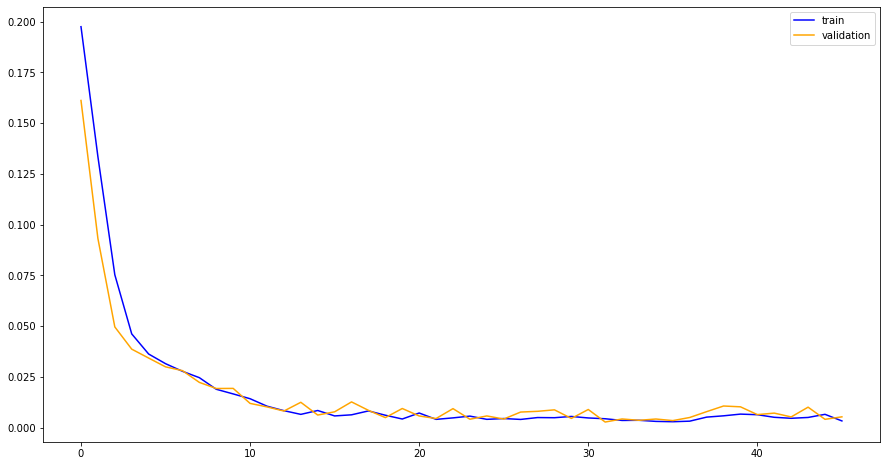

In [69]:
train = pd.DataFrame()
test = pd.DataFrame()
model = None
for i in range(1):
  # define model
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(400, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(tf.keras.layers.LSTM(400, activation='relu'))
  model.add(tf.keras.layers.Dense(2))
  model.compile(loss='mae', optimizer='adam')

  # early stopping
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

  # fit
  history = model.fit(train_X,
                      train_y,
                      epochs=100,
                      batch_size=4*24*365, # process one year at a time to capture annual seasonality
                      validation_data=(test_X, test_y),
                      verbose=2,
                      shuffle=False,
                      callbacks=[callback])

  # record results
  train[str(i)] = history.history['loss']
  test[str(i)] = history.history['val_loss']

# save last model
model.save('output/model.h5')

plt.plot(train, color='blue', label='train')
plt.plot(test, color='orange', label='validation')
plt.legend()
plt.show()

### Sanity Check

(668, 1, 23)
21/21 [==============================] - 0s 6ms/step


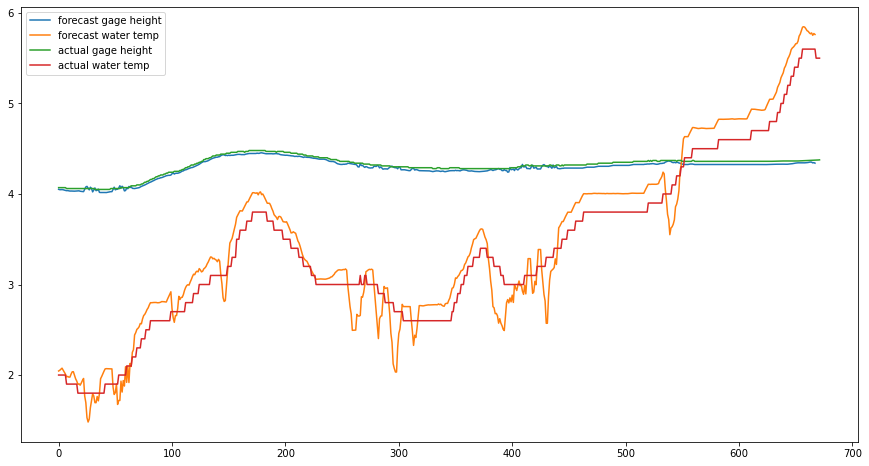

In [85]:
# get the last three days of data from the dataset (previously used for validation)
sanity = observations.tail(4 * 24 * 7).values
expected = sanity[:, 3:]

# expected[:, 0] = savgol_filter(expected[:, 0], 25, 3)

# scale
sanity = np.hstack((in_scaler.transform(sanity[:, :3]), out_scaler.transform(sanity[:, 3:])))

sanity_reshaped = series_to_supervised(sanity, 4, None, 1, None).values

sanity_X = sanity_reshaped[:, :-2]
sanity_X = sanity_X.reshape((sanity_X.shape[0], 1, sanity_X.shape[1]))
print(sanity_X.shape)

# predict
sanity_pred = model.predict(sanity_X)

# rescale
sanity_pred = out_scaler.inverse_transform(sanity_pred)

# graph
plt.plot(sanity_pred)
plt.plot(expected)
plt.legend(['forecast gage height', 'forecast water temp', 'actual gage height', 'actual water temp'])
plt.show()